In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to your dataset folder
DATASET_PATH = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets'


Mounted at /content/drive


In [2]:

#!pip install torchvision matplotlib scikit-learn

# Imports
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
import os
import shutil

source_path = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_anomaly_detection/bottle/test'
target_path = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/bottle_binary'

# Create target folders
os.makedirs(os.path.join(target_path, 'good'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'defective'), exist_ok=True)

# Copy 'good' images
good_src = os.path.join(source_path, 'good')
good_dst = os.path.join(target_path, 'good')
for fname in os.listdir(good_src):
    shutil.copy(os.path.join(good_src, fname), os.path.join(good_dst, fname))

# Copy all defect images into 'defective'
for folder in os.listdir(source_path):
    if folder == 'good':
        continue
    defect_src = os.path.join(source_path, folder)
    for fname in os.listdir(defect_src):
        shutil.copy(os.path.join(defect_src, fname), os.path.join(target_path, 'defective', f"{folder}_{fname}"))

print("Bottle_binary/ created at:", target_path)


Bottle_binary/ created at: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/bottle_binary


In [4]:
from pathlib import Path
from PIL import Image

def check_images(root_dir):
    broken = []
    for path in Path(root_dir).rglob("*.png"):
        try:
            with Image.open(path) as img:
                img.verify()
        except Exception as e:
            broken.append(str(path))
    return broken

broken = check_images('/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/bottle_binary')
print(f"Found {len(broken)} corrupted images.")

for path in broken:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")
    else:
        print(f"Skipped missing file: {path}")

Found 0 corrupted images.


In [5]:
!cp -r "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/bottle_binary" /content/

In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

DATASET_PATH = '/content/bottle_binary'

# Transform: Resize to 224x224, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Split 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Show class mapping
print("✅ Classes:", full_dataset.classes)
print("✅ Class indices:", full_dataset.class_to_idx)


✅ Classes: ['defective', 'good']
✅ Class indices: {'defective': 0, 'good': 1}


In [7]:
import torch
import torch.nn as nn
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer (fc) with a new classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes

# Move to GPU/CPU
model = model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


In [8]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Start small — you can increase later

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/5] - Loss: 0.3996
Epoch [2/5] - Loss: 0.2178
Epoch [3/5] - Loss: 0.1859
Epoch [4/5] - Loss: 0.1244
Epoch [5/5] - Loss: 0.1015


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Results
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

print("✅ Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

✅ Classification Report:
              precision    recall  f1-score   support

   defective       0.98      1.00      0.99       114
        good       1.00      0.88      0.93        16

    accuracy                           0.98       130
   macro avg       0.99      0.94      0.96       130
weighted avg       0.98      0.98      0.98       130

✅ Confusion Matrix:
[[114   0]
 [  2  14]]


In [10]:
!cp -r "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_binary" /content/

In [ ]:
# import os
# import shutil

# # Source: All categories inside mvtec_anomaly_detection
# mvtec_path = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_anomaly_detection'
# output_path = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_binary'

# # Create output folders
# os.makedirs(os.path.join(output_path, 'good'), exist_ok=True)
# os.makedirs(os.path.join(output_path, 'defective'), exist_ok=True)

# # Go through each category (e.g., bottle, pill)
# for category in os.listdir(mvtec_path):
#     category_test_path = os.path.join(mvtec_path, category, 'test')
#     if not os.path.isdir(category_test_path):
#         continue

#     for subfolder in os.listdir(category_test_path):
#         full_path = os.path.join(category_test_path, subfolder)
#         if not os.path.isdir(full_path):
#             continue

#         for fname in os.listdir(full_path):
#             src = os.path.join(full_path, fname)

#             if subfolder == 'good':
#                 dst = os.path.join(output_path, 'good', f'{category}_{fname}')
#             else:
#                 dst = os.path.join(output_path, 'defective', f'{category}_{subfolder}_{fname}')

#             shutil.copy(src, dst)

# print("✅ Dataset created at:", output_path)


✅ Dataset created at: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_binary


In [11]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

DATASET_PATH = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_binary'

# Transform: Resize to 224x224, normalize like ResNet expects
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Split: 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print classes
print("✅ Classes:", full_dataset.classes)
print("✅ Total Images:", len(full_dataset))
print("✅ Class indices:", full_dataset.class_to_idx)


✅ Classes: ['defective', 'good']
✅ Total Images: 1725
✅ Class indices: {'defective': 0, 'good': 1}


In [12]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50
model = models.resnet50(weights='IMAGENET1K_V1')  # New way instead of pretrained=True

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: defective, good

# Move to GPU/CPU
model = model.to(device)


Using device: cuda


In [13]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 8  # Feel free to increase this
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/8] - Loss: 0.5515
Epoch [2/8] - Loss: 0.5214
Epoch [3/8] - Loss: 0.4849
Epoch [4/8] - Loss: 0.4694
Epoch [5/8] - Loss: 0.4372
Epoch [6/8] - Loss: 0.4039
Epoch [7/8] - Loss: 0.4968
Epoch [8/8] - Loss: 0.4522


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print results
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

print(" Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

   defective       0.82      0.87      0.85       244
        good       0.64      0.55      0.59       101

    accuracy                           0.78       345
   macro avg       0.73      0.71      0.72       345
weighted avg       0.77      0.78      0.77       345

 Confusion Matrix:
[[212  32]
 [ 45  56]]


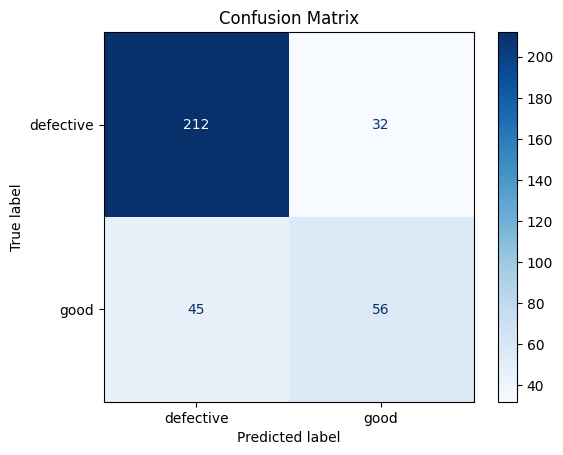

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix as image
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [16]:
import matplotlib.pyplot as plt

def show_preds(model, loader, class_names, num_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                image = np.clip(image, 0, 1)

                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[preds[i]]}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= num_images:
                    return


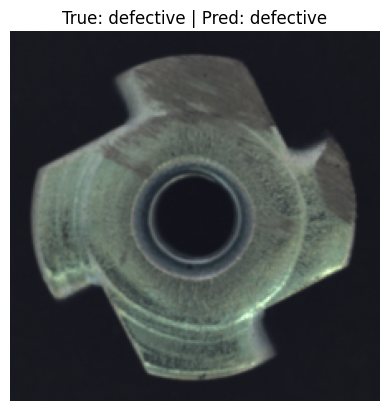

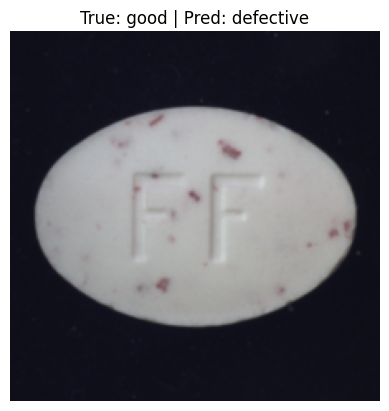

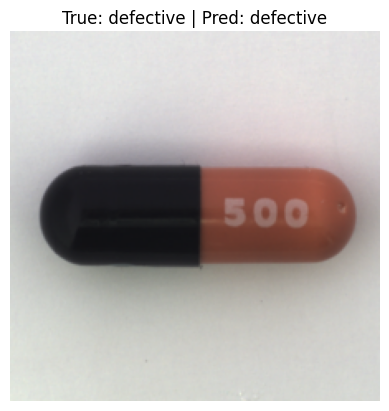

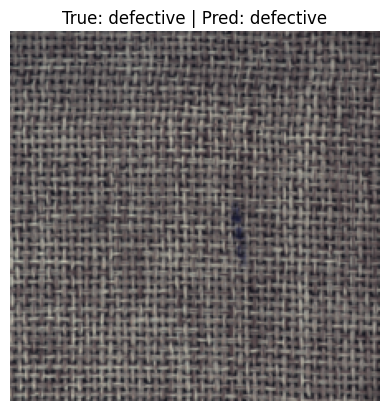

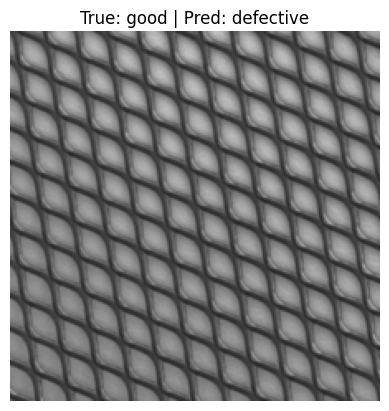

In [17]:
show_preds(model, val_loader, full_dataset.classes)


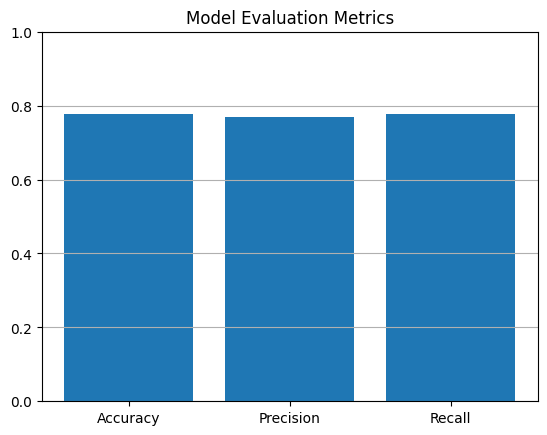

In [18]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()
